# OCR (Optical Character Recognition)
- Text Detection + Text Recognition
  - Text detection
    - 문자의 영역을 검출
    - object detection 기법과 segmentation 기법을 활용
    - 문자가 가지는 독특한 특성까지 고려
  - Text recognition
    - 문자를 인식

**구현할 모델 구조**  
- Text detector: Segmentation기반의 [CRAFT](http://arxiv.org/pdf/1904.01941) 활용한 keras-ocr
- Text recognition
  - [CRNN code](./0305_ocr_recognition_model.ipynb)
  - 모델 학습 후 수렴 결과  
    ![crnn_graph](./images/crnn_graph.png)  
  - 테스트 결과  
    ![text_recog_result](./images/text_recog_result.png)  
    ![result](./images/result.png)

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


### Detector

In [2]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


In [3]:
import os
from keras_ocr.detection import Detector

HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [ ]:
from PIL import Image, ImageDraw

def detect_text(img_path):
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # 배치 크기를 위해서 dimension을 확장해주고 keras-ocr의 입력 차원에 맞게 H,W,C로 변경
    image_batch = np.expand_dims(image, axis=0)

    # 배치의 첫 번째 결과만 가져옴
    detected_results = detector.detect(image_batch)
    ocr_result = detected_results[0]
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    # ocr_result = [np.array([(x, y) for (y, x) in box]) for box in first_result]

    result_img = Image.fromarray(image)
    img_draw = ImageDraw.Draw(result_img)
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')

        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        
        cropped_imgs.append(result_img.crop(word_box))

    return result_img, cropped_imgs

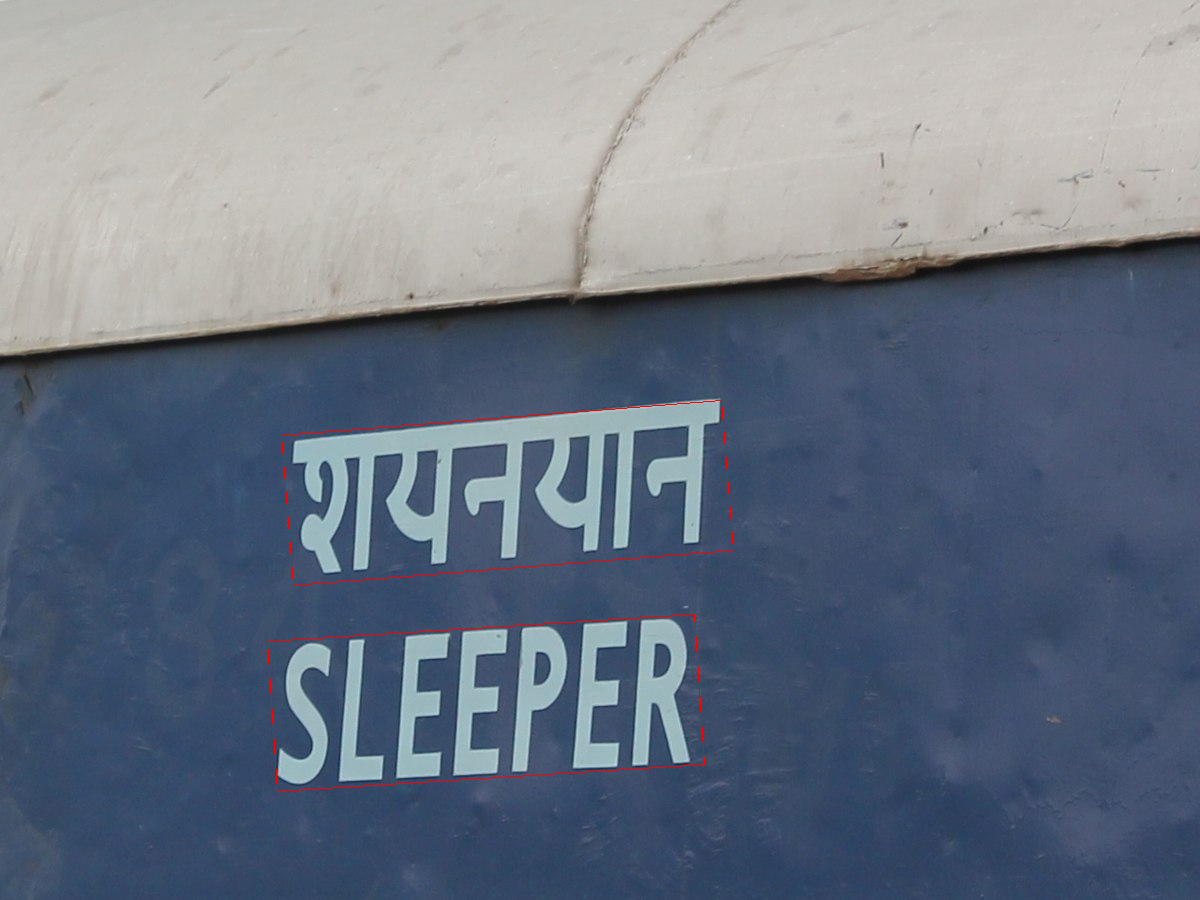

In [5]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

### Recognition model
![rcnn](https://d3s0tskafalll9.cloudfront.net/media/original_images/e-23-2.crnn.png)
- CRNN의 구조는 위 그림에서 아래부터 올라가는 순서
![arch](https://d3s0tskafalll9.cloudfront.net/media/original_images/e-23-3.crnn_structure.png)
- 입력이미지를 Convolution Layer를 통해 Feature를 추출하여 추출된 Feature를 얻음
-  **Recurrent Layer**는 추출된 Feature의 전체적인 Context를 파악하고 다양한 output의 크기에 대응이 가능
- **Transcription layer(Fully connected layer)**는 step마다 어떤 character의 확률이 높은지 예측

In [6]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

In [7]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

In [9]:
checkpoint_path = HOME_DIR + '/model_checkpoint_accuracy.hdf5'

model = build_crnn_model()
model.load_weights(checkpoint_path)

input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

In [10]:
from IPython.display import display

def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    indexes = [idx for idx in indexes if idx != -1]
    
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

In [11]:
def recognize_img(pil_img, input_img_size=(100,32)):
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    
    return result

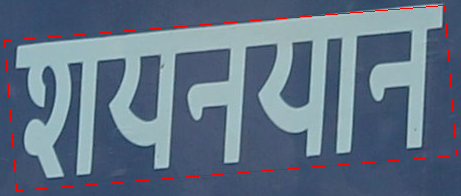

Recognized text : YRIRNT


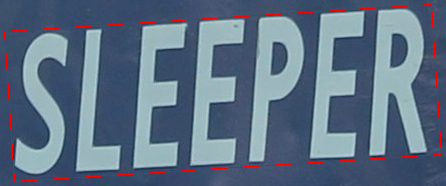

Recognized text : SLEEPER


In [12]:
for _img in cropped_img:
    result = recognize_img(_img)
    display(Image.fromarray(np.array(_img).astype(np.uint8)))
    print(f'Recognized text : {result}')

----

## OCR function

In [13]:
def ocr(image_path):
    ocr_result = []
    
    # detect texts from image
    detected_image, cropped_images = detect_text(image_path)
    
    # recognize texts from cropped images
    for _cropped_image in cropped_images:
        result = recognize_img(_cropped_image)
        ocr_result.append({
            'text': result,
            'image': _cropped_image
        })
    
    return ocr_result

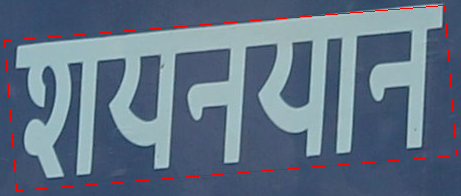

Recognized text : YRIRNT


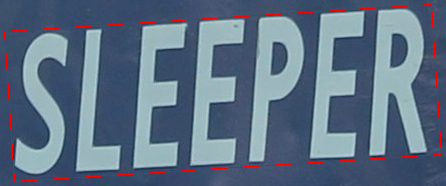

Recognized text : SLEEPER


In [14]:
ocr_list = ocr(SAMPLE_IMG_PATH)
for info in ocr_list:
    display(Image.fromarray(np.array(info['image']).astype(np.uint8)))
    print(f'Recognized text : {info["text"]}')

---

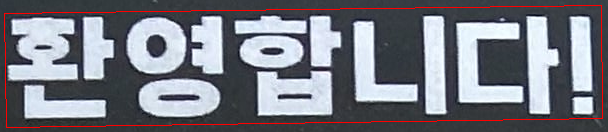

Recognized text : EHOGELICH


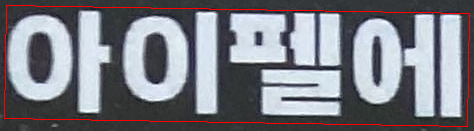

Recognized text : OFOPHIOL


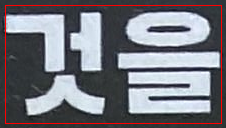

Recognized text : LGRIAS


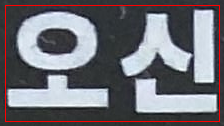

Recognized text : SPTL


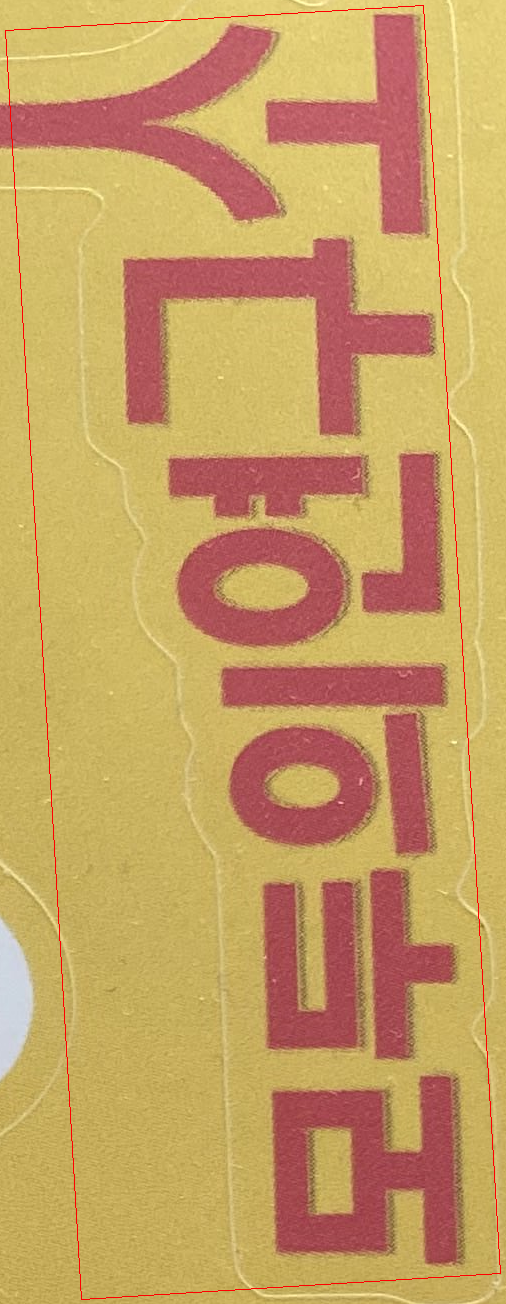

Recognized text : AHES


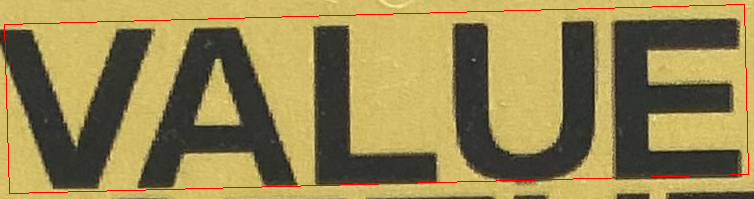

Recognized text : VALUE


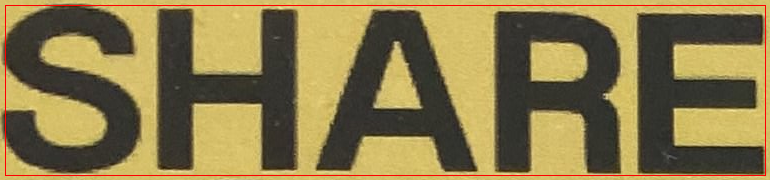

Recognized text : SHARE


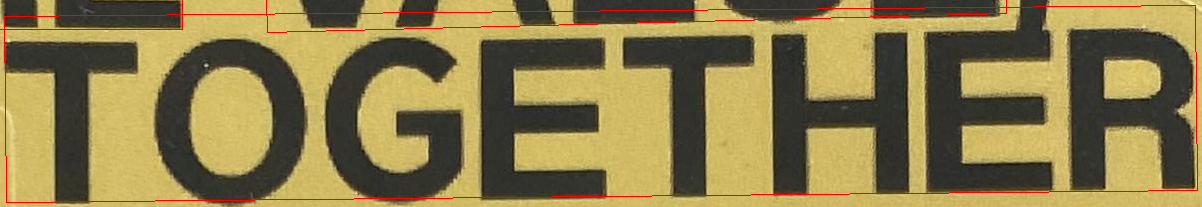

Recognized text : TROGETHER


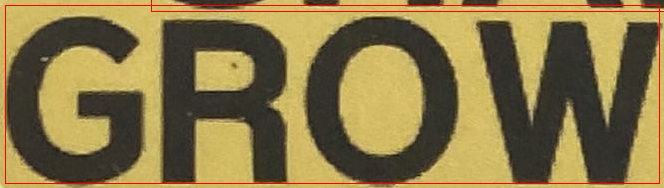

Recognized text : GRON


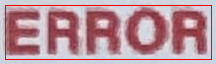

Recognized text : EROH


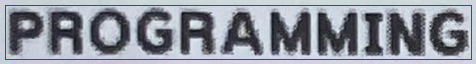

Recognized text : PROGRAMING


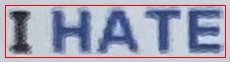

Recognized text : IHATE


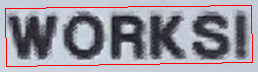

Recognized text : WORKSI


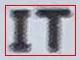

Recognized text : FETY


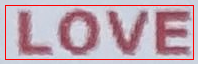

Recognized text : EQE


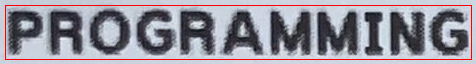

Recognized text : PROGRAMING


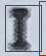

Recognized text : FGE


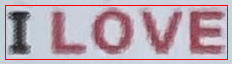

Recognized text : ILQVE


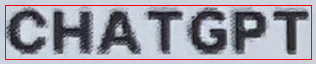

Recognized text : CHATGPT


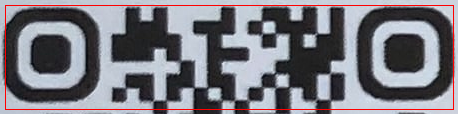

Recognized text : OUTLNO


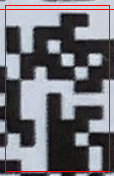

Recognized text : BCPGAT


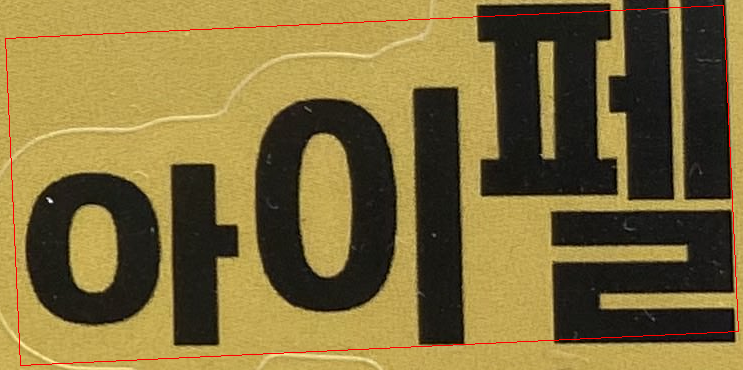

Recognized text : OROHEL


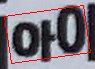

Recognized text : TIOHOT


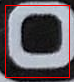

Recognized text : IECY


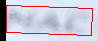

Recognized text : RTY


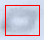

Recognized text : EANS


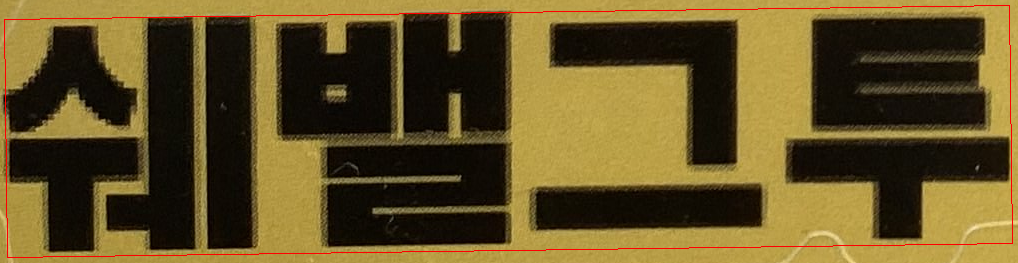

Recognized text : AIMETE


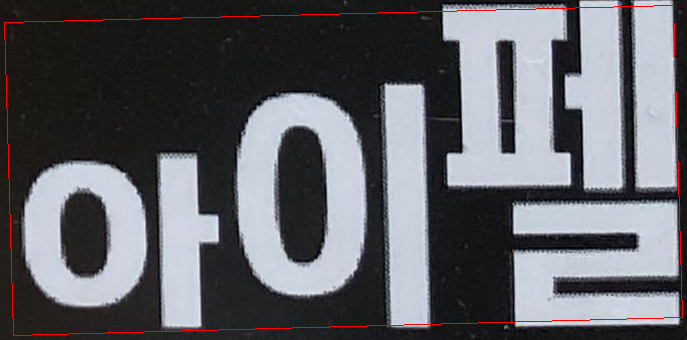

Recognized text : OROHL


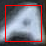

Recognized text : PECING


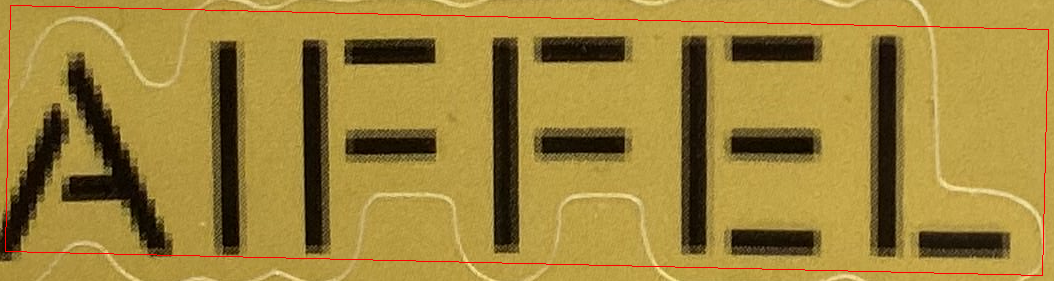

Recognized text : ALIEHEL


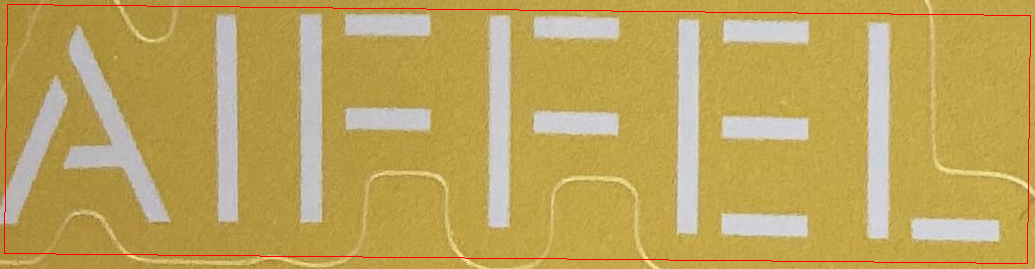

Recognized text : CALNCS


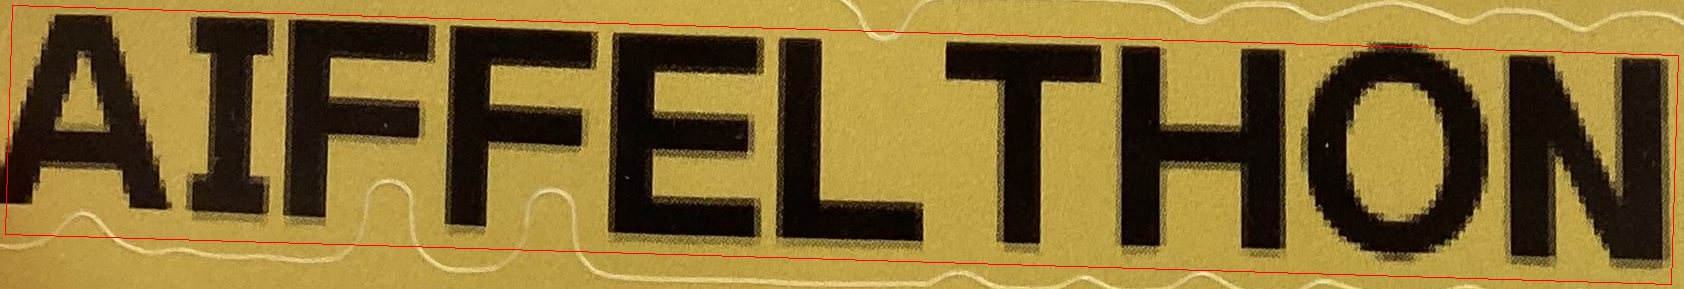

Recognized text : ALFFELTHON


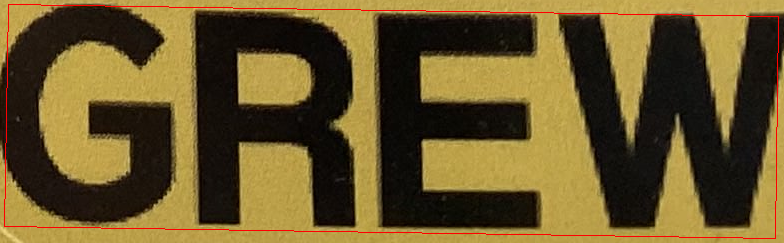

Recognized text : GREN


In [15]:
AIFFEL_IMG_PATH = HOME_DIR + '/images/aiffel.jpg'
aiffel_ocr_list = ocr(AIFFEL_IMG_PATH)
for info in aiffel_ocr_list:
    display(Image.fromarray(np.array(info['image']).astype(np.uint8)))
    print(f'Recognized text : {info["text"]}')

- 네이버 클로바에서 나온 CRAFT를 디텍터로 사용해서 그런지, 영어뿐만 아니라 한글을 감지하는 성능은 좋은 듯
- 하지만 문자 인식은 하나도 안 됨
- 영어도 성능이 많이 떨어짐
- keras-ocr document를 보니, end-to-end training 할 때 1000 epochs을 돌림
  - 현 테스트는 겨우 20 epochs.. 
  - pretrained models로 테스트해보자!~ [이동](./0305_ocr-with-pretrained-model.ipynb)